In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import grad, jit, vmap
from jax import random
import jax

from typing import Sequence
from jaxtyping import Array, Float, Int, PyTree

import equinox as eqx
import optax
import chex

from dataclasses import dataclass
from functools import partial

jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [6]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

jax==0.3.25
equinox==0.9.2
optax==0.1.4
chex==0.1.5
pip==23.1.2


In [3]:
# Black Scholes
# helper analytics    
@jit
def bsPrice(spot, strike, vol, T):
    d1 = (jnp.log(spot/strike) + 0.5 * vol * vol * T) / vol / jnp.sqrt(T)
    d2 = d1 - vol * jnp.sqrt(T)
    return spot * norm.cdf(d1) - strike * norm.cdf(d2)

@jit
def bsDelta(spot, strike, vol, T):
    d1 = (jnp.log(spot/strike) + 0.5 * vol * vol * T) / vol / jnp.sqrt(T)
    return norm.cdf(d1)

@jit
def bsVega(spot, strike, vol, T):
    d1 = (jnp.log(spot/strike) + 0.5 * vol * vol * T) / vol / jnp.sqrt(T)
    return spot * jnp.sqrt(T) * norm.pdf(d1)

@dataclass
class BlackScholes:
    
    spot: int = 1
    vol: float = 0.2
    T1: int = 1
    T2: int = 2
    K: float = 1.10
    volMult: float = 1.5
                        
    # training set: returns S1 (mx1), C2 (mx1) and dC2/dS1 (mx1)
    # @partial(jit, static_argnums=(0,))
    def trainingSet(self, m, anti=True, seed=42):
    
        key = random.PRNGKey(seed)
        # 2 sets of normal returns
        returns = random.normal(key, shape=(m, 2))

        # SDE
        vol0 = self.vol * self.volMult
        R1 = jnp.exp(-0.5*vol0*vol0*self.T1 + vol0*jnp.sqrt(self.T1)*returns[:,0])
        R2 = jnp.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    + self.vol*jnp.sqrt(self.T2-self.T1)*returns[:,1])
        S1 = self.spot * R1
        S2 = S1 * R2 

        # payoff
        pay = jnp.maximum(0, S2 - self.K)
        
        # two antithetic paths
        if anti:
            
            R2a = jnp.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    - self.vol*jnp.sqrt(self.T2-self.T1)*returns[:,1])
            S2a = S1 * R2a             
            paya = jnp.maximum(0, S2a - self.K)
            
            X = S1
            Y = 0.5 * (pay + paya)
    
            # differentials
            Z1 =  jnp.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
            Z2 =  jnp.where(S2a > self.K, R2a, 0.0).reshape((-1,1)) 
            Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            X = S1
            Y = pay
            
            # differentials
            Z =  jnp.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
        
        return X.reshape([-1,1]), Y.reshape([-1,1]), Z.reshape([-1,1])
    
    # test set: returns a grid of uniform spots 
    # with corresponding ground true prices, deltas and vegas
    def testSet(self, lower=0.35, upper=1.65, num=100, seed=42):
        
        spots = jnp.linspace(lower, upper, num).reshape((-1, 1))
        # compute prices, deltas and vegas
        prices = bsPrice(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        deltas = bsDelta(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        vegas = bsVega(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        return spots, spots, prices, deltas, vegas   

In [4]:
# we want a data class that remembers all the transformations we do to the data

# add both train and test data set to the class

class DataSet:

    @dataclass
    class Data:
        def __init__(self, data: Array):
            self.data = data
            self.mean = jnp.mean()
            self.std = jnp.std()

        def normalize(self):
            return (self.data - self.mean) / self.std

    train_data: Data
    test_data: Data

    def __init__(self, train_data: Array, test_data: Array):
        self.train_data = self.Data(train_data, jnp.mean(train_data), jnp.std(train_data))
        self.test_data = self.Data(test_data, jnp.mean(test_data), jnp.std(test_data))




# class DataNormalizer:

#     @dataclass
#     class Data:
#         data: Array
#         mean: Float
#         std: Float

#     def __init__(self, data: Array):
#         self.unnormalized = self.Data(data, jnp.mean(data), jnp.std(data))
#         self.normalized = self.Data((data - self.unnormalized.mean) / self.unnormalized.std, 0, 1)

#     def denormalize(self):
#         return self.normalized * self.unnormalized.std + self.unnormalized.mean


In [5]:
bs = BlackScholes()
x_train, y_train, dydx_train = bs.trainingSet(8192)
x_test, x_axis, y_test, dydx_test, vegas = bs.testSet(num=1000)

In [6]:
def plot_training_data(x_train, y_train, dydx_train, x_test, y_test, x_axis, dydx_test):
    plt.title("Training Data")
    # the same as plt.scatter(x_train, y_train) but with a thinner line is:
    plt.plot(x_train, y_train, 'r.', markersize=1)
    # now the other two with a thinner line:
    plt.plot(x_test, y_test, 'b.', markersize=1)
    plt.plot(x_train, dydx_train, 'g.', markersize=1)
    # plt.plot(x_axis, dydx_test, 'g.', markersize=1)
    # corresponding legend:
    plt.legend(['Training Data', 'True Price', 'Training Delta'], loc='upper left')
    plt.show()

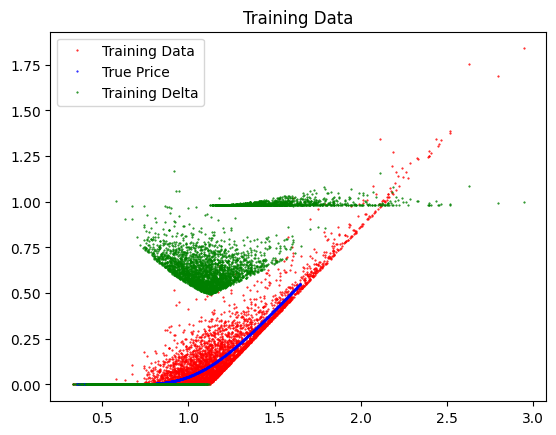

In [7]:
plot_training_data(x_train, y_train, dydx_train, x_test, y_test, x_axis, dydx_test)

In [8]:

class NormalizedData:
    def __init__(self, data: Array):
        self._mean = jnp.mean(data)
        self._std = jnp.std(data)
        self.data = (data - self._mean) / self._std

    def __repr__(self) -> str:
        return f"NormalizedData(data={self.data})"

    def denormalize(self, data: Array):
        return data * self._std + self._mean

# class UnnormalizedData:
    # def __init__(self, data: NormalizedData)

In [9]:
def normalize(data: Array):
    mean = jnp.mean(data)
    std = jnp.std(data)
    return (data - mean) / std, mean, std

# normalize data
x_train, x_train_mean, x_train_std = normalize(x_train)
y_train, y_train_mean, y_train_std = normalize(y_train)
dydx_train, dydx_train_mean, dydx_train_std = normalize(dydx_train)

In [10]:
# Hyperparameters
batch_size = 128
learning_rate = 0.01
num_epochs = 10
seed = 42

key = jax.random.PRNGKey(seed)

In [11]:
key, subkey = jax.random.split(key)
model = eqx.nn.MLP(key=subkey, in_size=1, out_size=1, width_size=20, depth=3, activation=jax.nn.elu)

In [12]:
def trunc_init(weight: Array, key: jax.random.PRNGKey) -> Array:
  out, in_ = weight.shape
  print(out, in_)
  stddev = jnp.sqrt(1 / in_)
  return jax.nn.initializers.glorot_normal()(key, (out, in_))

def init_linear_weight(model, init_fn, key):
  is_linear = lambda x: isinstance(x, eqx.nn.Linear)
  get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
  weights = get_weights(model)
  new_weights = [init_fn(weight, subkey)
                 for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
  new_model = eqx.tree_at(get_weights, model, new_weights)
  return new_model

key, subkey = jax.random.split(key)

model = init_linear_weight(model, trunc_init, key)

20 1
20 20
20 20
1 20


In [13]:
def loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], y: Float[Array, "batch"]) -> Float:
    predictions = vmap(model)(x)
    targets = y
    chex.assert_type([predictions], float)
    if targets is not None:
        # Avoid broadcasting logic for "-" operator.
        chex.assert_equal_shape((predictions, targets))
    errors = predictions - targets if targets is not None else predictions
    result = jnp.mean(errors ** 2)
    chex.assert_type([result], float)
    return result

In [14]:
res = vmap(model)(x_train)
print(res)
res.shape

[[-0.35076958]
 [-0.35241127]
 [-0.2928294 ]
 ...
 [-0.2950117 ]
 [-0.3194747 ]
 [-0.31721544]]


(8192, 1)

In [15]:
def train(model: eqx.nn.MLP,
          x: Float[Array, "n"],
          y: Float[Array, "n"],
          optim: optax.GradientTransformation,
          steps: int
          ) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   y: Float[Array, "batch"]
                   ):
        loss_value, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    n_batches = (len(x) // batch_size)
    for step in range(n_batches):
        batch_x = x[step*batch_size:(step+1)*batch_size]
        batch_y = y[step*batch_size:(step+1)*batch_size]

        model, opt_state, loss_value = train_step(model, opt_state, batch_x, batch_y)

        if (step % 100 == 0) or (step == steps-1):
            test_loss = loss_fn(model, (x_test - x_train_mean) / x_train_std, (y_test - y_train_mean) / y_train_std)
            print(f"step: {step}, train_loss: {loss_value}, test_loss: {test_loss}")
    
    return model

In [16]:
optim = optax.adam(learning_rate)
model = train(model, x_train, y_train, optim, steps=1000)

step: 0, train_loss: 0.9972524046897888, test_loss: 0.28816652297973633


(1000, 1)
RMSE: 0.006005485542118549


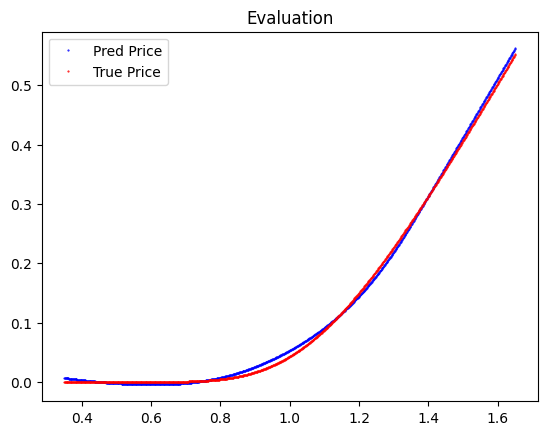

In [17]:
# predict
# x_test = x_axis
x = (x_test - x_train_mean) / x_train_std
pred_y = vmap(model)(x)
# unscale predictions
pred_y = pred_y * y_train_std + y_train_mean
print(pred_y.shape)
# evaluate
def eval_rmse(y_true: Array, y_pred: Array) -> float:
    return jnp.sqrt(jnp.mean((y_true - y_pred) ** 2))

# print the above line:
print(f"RMSE: {eval_rmse(y_test, pred_y)}")

plt.title("Evaluation")
plt.plot(x_test, pred_y, 'b.', markersize=1)
plt.plot(x_test, y_test, 'r.', markersize=1)
plt.legend(['Pred Price', 'True Price'], loc='upper left')
plt.show()

(1000, 1)
0.65816414


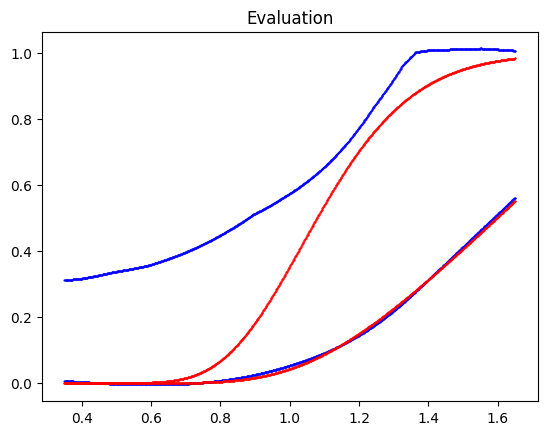

In [18]:
# vmap(eqx.filter_grad(model))(x_test)

# eqx.filter_grad(model)(jnp.array([1.0]))

# eqx.filter_grad(lambda x: model(x))(jnp.array([1.0]))

def eval_fn(x):
    return model(jnp.array([x]))

# fn  = jax.grad(eval_fn)
# vmap(fn)(x_test)

# vmap(jax.grad(eval_fn))(x_test)

# vmap(eqx.filter_grad(eval_fn))(x_test)

# # fn  = eqx.filter_grad(model)
# fn(jnp.array([1.0]))
print(x_test.shape)
primals, fn = eqx.filter_vjp(vmap(model), x)

# s = jnp.zeros_like(primals)
s = jnp.ones_like(primals)
# s = s.at[0].set(1.0)

pred_deltas, = fn(s)

res = jax.jacrev(vmap(model))(x_test)
print(res[0, 0, 0, 1] * dydx_train_std + dydx_train_mean)
# print(res.flatten() * dydx_train_std + dydx_train_mean)

primals = primals * y_train_std + y_train_mean
# pred_deltas = vmap(model)(x_test)

pred_deltas = pred_deltas * dydx_train_std +dydx_train_mean
plt.title("Evaluation")
plt.plot(x_test, primals, 'b.', markersize=1)
plt.plot(x_test, y_test, 'r.', markersize=1)
plt.plot(x_test, pred_deltas, 'b.', markersize=1)
plt.plot(x_test, dydx_test, 'r.', markersize=1)
plt.show()

In [19]:
class MakeScalar(eqx.Module):
    model: eqx.Module

    def __call__(self, *args, **kwargs):
        out = self.model(*args, **kwargs)
        return jnp.reshape(out, ())

modela = MakeScalar(model)

res = vmap(jax.grad(modela))(x_test) * dydx_train_std + dydx_train_mean

# vmap(jax.jacrev(model))(x_test) * dydx_train_std + dydx_train_mean

In [20]:
# eqx.filter_jvp(model, x_test, jnp.array([1.0]))

# jax.jvp(model, (jnp.array([1.0]),), (jnp.array([1.0]),))

J = jax.jacrev(model)

# J(jnp.array([1.0]))

# pred_dy = vmap(J)(x_test).flatten()
# pred_dy = pred_dy * dydx_train_std + dydx_train_mean

# plt.title("Evaluation")
# plt.plot(x_test, pred_dy, 'b.', markersize=1)
# plt.show()